In [10]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [11]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [12]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [13]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
input_shape = X_train_scaled.shape[1]

photo_input = keras.Input(shape=(input_shape,), name='photo_input')
x = layers.Dense(64, activation='relu', name='layer0_Dense64')(photo_input)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', name='layer1_Dense128')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', name='layer2_Dense256')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', name='layer3_Dense512')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', name='layer4_Dense256')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', name='layer5_Dense128')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu', name='layer6_Dense64')(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(1, name='logM_star')(x)

model = keras.Model(inputs=photo_input, outputs=output, name='PhotoOnly_Model_v1.0')

# Loading the weights into corresponding layers
model.load_weights(f'models/spec_photo_model_v1.0.h5', by_name=True, skip_mismatch=True)

model.get_layer('layer1_Dense128').trainable = True
model.get_layer('layer2_Dense256').trainable = False
model.get_layer('layer3_Dense512').trainable = True
model.get_layer('layer4_Dense256').trainable = False
model.get_layer('layer5_Dense128').trainable = True

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "PhotoOnly_Model_v1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 photo_input (InputLayer)    [(None, 39)]              0         
                                                                 
 layer0_Dense64 (Dense)      (None, 64)                2560      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 layer1_Dense128 (Dense)     (None, 128)               8320      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 layer2_Dense256 (Dense)     (None, 256)               33024     
                                                                 
 dropout_9 (Dropout)         (None, 256)      

In [17]:
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10


6093/6093 [==============================] - 24s 4ms/step - loss: 9237214.0000 - mae: 1140.4155 - mse: 9237214.0000 - mape: 1982.4663 - val_loss: 8862345.0000 - val_mae: 1402.9700 - val_mse: 8862345.0000 - val_mape: 4711.6465
Epoch 2/10
6093/6093 [==============================] - 23s 4ms/step - loss: 3544178.7500 - mae: 649.1657 - mse: 3544178.7500 - mape: 1976.9540 - val_loss: 1086530.8750 - val_mae: 303.5413 - val_mse: 1086530.8750 - val_mape: 451.2770
Epoch 3/10
6093/6093 [==============================] - 23s 4ms/step - loss: 1159626.1250 - mae: 277.9192 - mse: 1159626.1250 - mape: 568.5038 - val_loss: 961846.3125 - val_mae: 297.3518 - val_mse: 961846.3125 - val_mape: 369.9939
Epoch 4/10
6093/6093 [==============================] - 23s 4ms/step - loss: 834775.3125 - mae: 233.8378 - mse: 834775.3125 - mape: 518.9362 - val_loss: 1159532.8750 - val_mae: 343.2411 - val_mse: 1159532.8750 - val_mape: 826.1871
Epoch 5/10
6093/6093 [==============================] - 23s 4ms/s

In [18]:
# Save weights from the trained model
model.save_weights('models/photo_only_model_v1.0.h5')

In [19]:
y_pred_full = model.predict(X_test_scaled)

# Evaluate accuracy metrics
mae = mean_absolute_error(y_test, y_pred_full)
r2 = r2_score(y_test, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))

print(f"Photometry-Only Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

1904/1904 [==============================] - 2s 1ms/step
Photometry-Only Model Evaluation:
Mean Absolute Error (MAE): 305.3683
Root Mean Squared Error (RMSE): 940.2389
R² Score: 0.8991


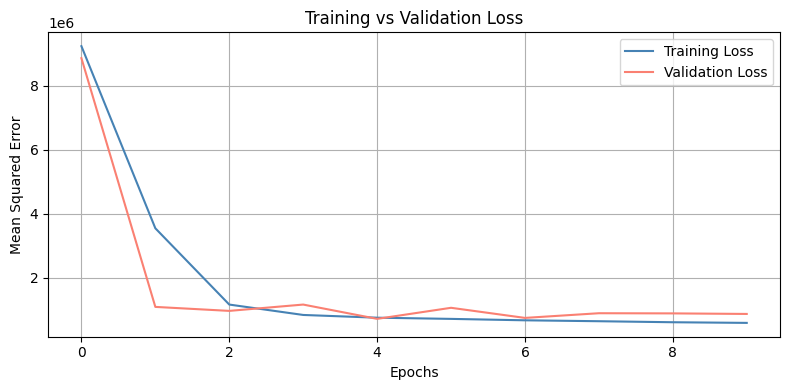

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='steelblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

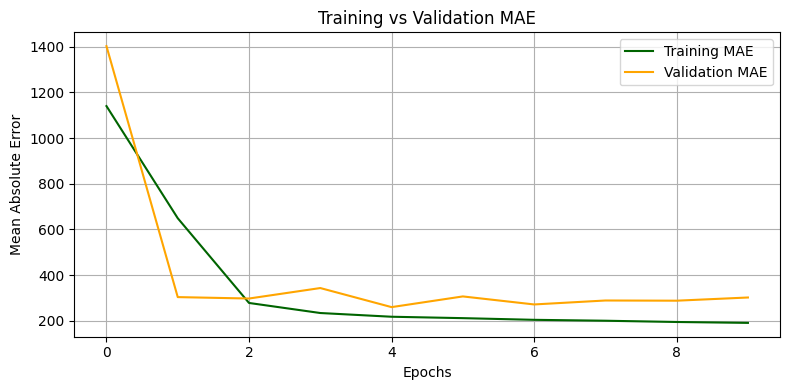

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Training MAE', color='darkgreen')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()